In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [5]:
dataset = pd.read_csv('bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")

In [6]:
dataset

,Price,Open,High,Low,Vol.,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32.97K,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47.71K,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112.43K,-1.00%,93229.35


In [7]:
# train-test
tstart = "2010-07-18"
tend = "2024-01-10"

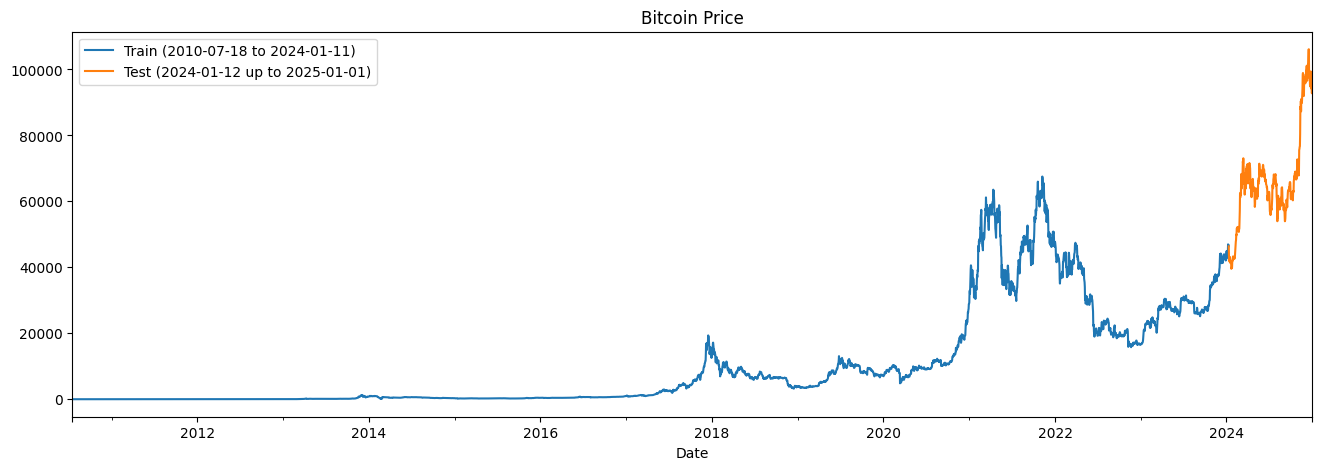

In [8]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2010-07-18 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin Price")
    plt.show()

train_test_plot(dataset, tstart, tend)

In [9]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Price"].values
    test = dataset.loc[tend_next:, "Price"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [10]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [12]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [13]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=125, activation="tanh", input_shape=(n_steps, features))))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 10 min
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - loss: 0.0086
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 6.9692e-04
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 5.1356e-04
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - loss: 4.6489e-04
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - loss: 3.8490e-04
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 3.4002e-04
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 3.0297e-04
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 2.7604e-04
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 2.6240e-04
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - loss: 2.5072e-04
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 2.3558e-04
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - loss: 2.1925e-04
Epoch 13/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - loss: 2.1022e-04
Epoch 14/50
153/153 ━━━━━━━━━━━━━━━━━━

In [15]:
dataset_total = dataset.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [16]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [17]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error is {rmse:.2f}.")

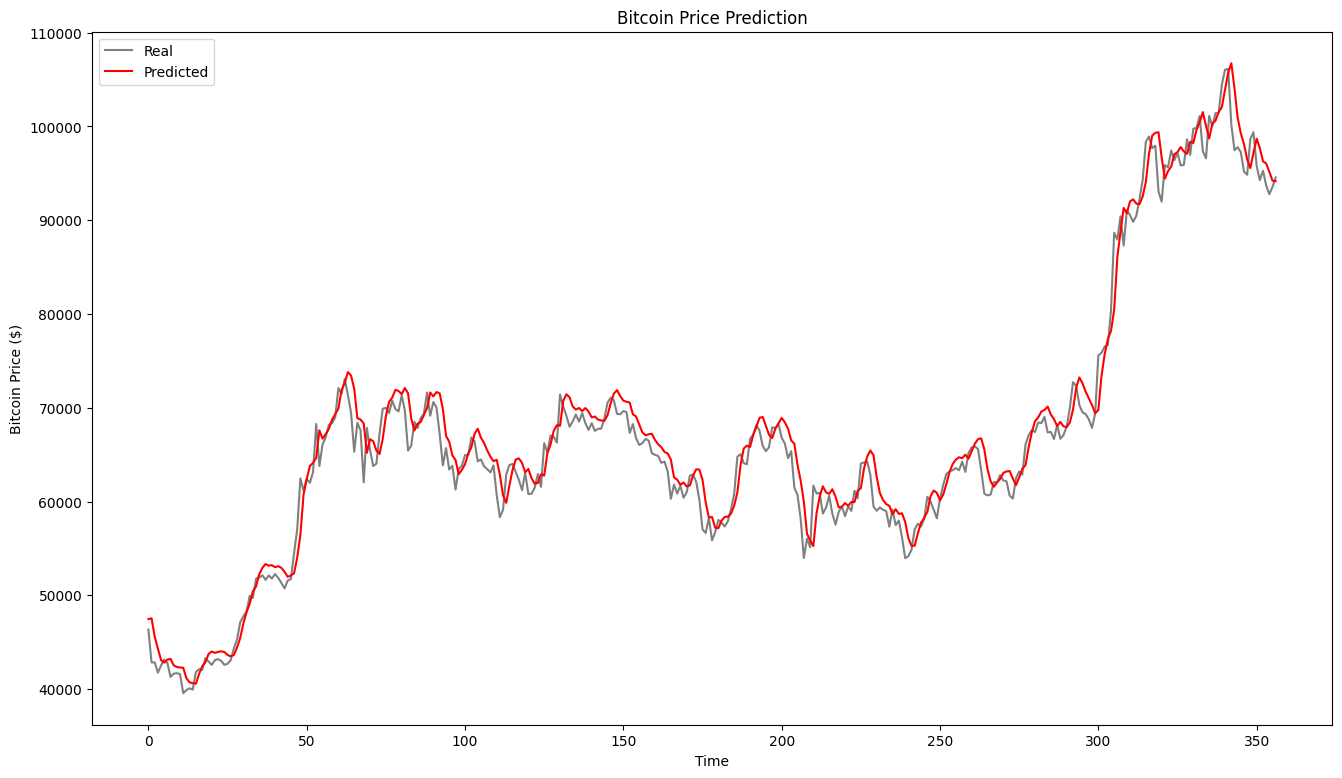

In [18]:
plot_predictions(test_set, predicted_stock_price)

In [19]:
# RMSE represents the square root of the variance of the residuals
# it may seem to be pretty high but considering the order of magnitude, I think it is pretty precise
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 2200.62.


In [20]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 10 min
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 0.0087
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 4.3745e-04
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 3.4537e-04
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 3.3299e-04
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 2.6398e-04
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 2.4136e-04
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 2.2471e-04
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 2.1246e-04
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 2.0291e-04
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 1.9587e-04
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 1.9154e-04
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 1.8879e-04
Epoch 13/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 1.8562e-04
Epoch 14/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/st

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


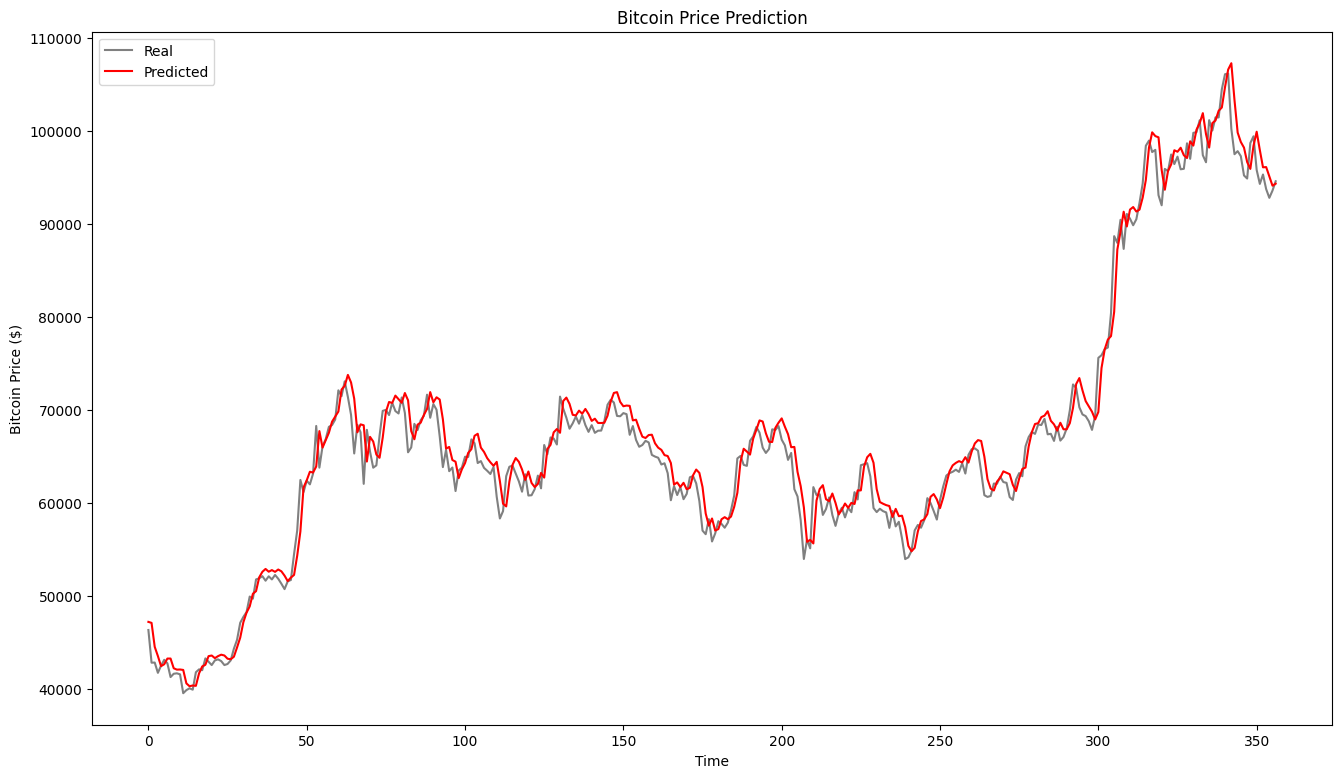

In [22]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

### Short Comparison

We can compare these two charts and conclude that the **GRU** model is more accurate in predicting latest (higher) prices and ramps up the lower prices at the earlier periods (especially where Time between 200 and 600). The RMSE here is still less, probably because the higher prices have smaller residuals, overshadowing poorer performance earlier (in Time).

On the other hand, **LSTM** is more precise in predicting earlier price movements (compare Time between 200 and 600), whereas it is less robust in identifying the most recent trends.

In [23]:
# Improved a bit with GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 2047.40.


To improve models & RMSE:
- increase `batch_size`
- increase or decrease `n_steps` in **split_sequence**
- train more epochs
- improve model structure (especially GRU)
- reducing dataset (e.g. start from 2017)
- separate normalization over different time windows
- extend `train_set` (e.g. to 0.85)
- try various activation functions